# CAFEHS is invariant to scaling of $\hat\beta$ and $S$

Here we want to verify the scale invariance of CAFEH-S.

That is, running CAFEH on $\hat\beta$ and $S$ would yield the same results as running CAFEH on $\tilde\beta = a \hat\beta$ and $\tilde S = a S$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cafeh.cafeh_summary import fit_cafeh_summary, fit_cafeh_z
from cafeh.cafeh_genotype import fit_cafeh_genotype

from cafeh.model_queries import *

## Set-up

### Simulate some data

First we simulate some data. We generate 3 phenotypes that all have a distinct causal variant, and a fourth causal variant shared across the 4

We generate multivariate normal "genotype" data where SNPs are correlated with their neighbors in an exponentially decaying manner.

In [2]:
np.random.seed(1)

t = 7  # number of phenotypes
n = 500  # number of samples
p = 1497  # number of features (SNPs)

# simulate some correlated features X
mix = np.exp(-np.abs(np.arange(p) - np.arange(p)[:, None])/50)
X = (np.random.normal(size=(n, p)) @ mix).T

# simulate phenotypes: each with a distinct causal variant and all with a shared causal variant
causal = np.zeros((t, p))
causal[0, [100, 500]] = 1
causal[1, [150, 500]] = 1
causal[2, [200, 500]] = 1

y = causal @ X + np.random.normal(size=(t, n)) * 3

### Compute summary statistics

Next we compute effect sizes and standard errors to use in the summary stat version of CAFEH

In [3]:
y_centered = y - y.mean(1)[:, None]
X_centered = X - X.mean(1)[:, None]

d = np.diag(X_centered @ X_centered.T)
B = (y_centered @ X_centered.T) / d[None]

sq_error = np.array([((y_centered[i][:, None] - X_centered.T * B[i])**2).sum(0) for i in range(t)])
stderr = np.sqrt(sq_error / (n-1) / d[None])
S = np.sqrt(B**2/n + stderr**2)
LD = np.corrcoef(X)

Text(0.5, 1.0, 'Simulation LD Matrix')

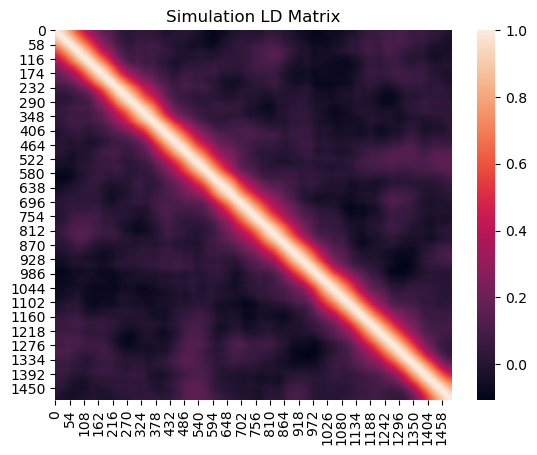

In [4]:
sns.heatmap(np.corrcoef(X))
plt.title('Simulation LD Matrix')

In [5]:
snp_ids = ['snp{}'.format(i) for i in range(p)]
sample_ids = ['sample{}'.format(i) for i in range(n)]
study_ids = ['study{}'.format(i) for i in range(t)]
covariate_ids = ['cov{}'.format(i) for i in range(5)]

In [6]:
# generate some dummy covariates
cov_df = pd.concat({t: pd.DataFrame(np.random.normal(size=(5, n)),
                                    index=covariate_ids, columns=sample_ids) for t in study_ids})

In [7]:
X_df = pd.DataFrame(X, index=snp_ids, columns=sample_ids)
y_df = pd.DataFrame(y, index=study_ids, columns=sample_ids)
LD_df = pd.DataFrame(LD, index=snp_ids, columns=snp_ids)
beta_df = pd.DataFrame(B, index=study_ids, columns=snp_ids)
stderr_df = pd.DataFrame(stderr, index=study_ids, columns=snp_ids)
z_df = pd.DataFrame(B/stderr, index=study_ids, columns=snp_ids)
n_df = pd.DataFrame(np.ones_like(B) * n, index=study_ids, columns=snp_ids)

X_df.to_csv('../example/X_example.tsv', sep='\t')
y_df.to_csv('../example/y_example.tsv', sep = '\t')
cov_df.to_csv('../example/cov_example.tsv', sep='\t')
LD_df.to_csv('../example/LD_example.tsv', sep='\t')
n_df.to_csv('../example/n_example.tsv', sep='\t')
beta_df.to_csv('../example/beta_example.tsv', sep='\t')
stderr_df.to_csv('../example/stderr_example.tsv', sep='\t')
z_df.to_csv('../example/z_example.tsv', sep='\t')


## Fitting CAFEH

Let's compare `fit_cafeh_summary` with multiple rescalingings of the data, and `fit_cafeh_z`.

### Fit CAFEH with summary stats (betas + standard errors OR z-scores)

The summary stat version of CAFEH is implimented in `CAFEHSummary`.

If you have effect sizes and standard error you can use `fit_cafeh_summary`.
If you have z-scores you can use `fit_cafeh_z`.

Please note that with `fit_cafeh_z`, the scale of the weights may not be comparable across multiple phenotypes, especially if there were a different number of samples in each phenotype, since z-scores conflate effect size and significance.

Implementation of `CAFEHSummary` is based off of the Regression form Summary Statistics (RSS) likelihood of Zhu and Stephens [1]. We impliment a stochastic optimization routine which at each iteration we sample an active SNP for each component according the to current posterior estimates `pi`.

### Fit with betas and standard errors

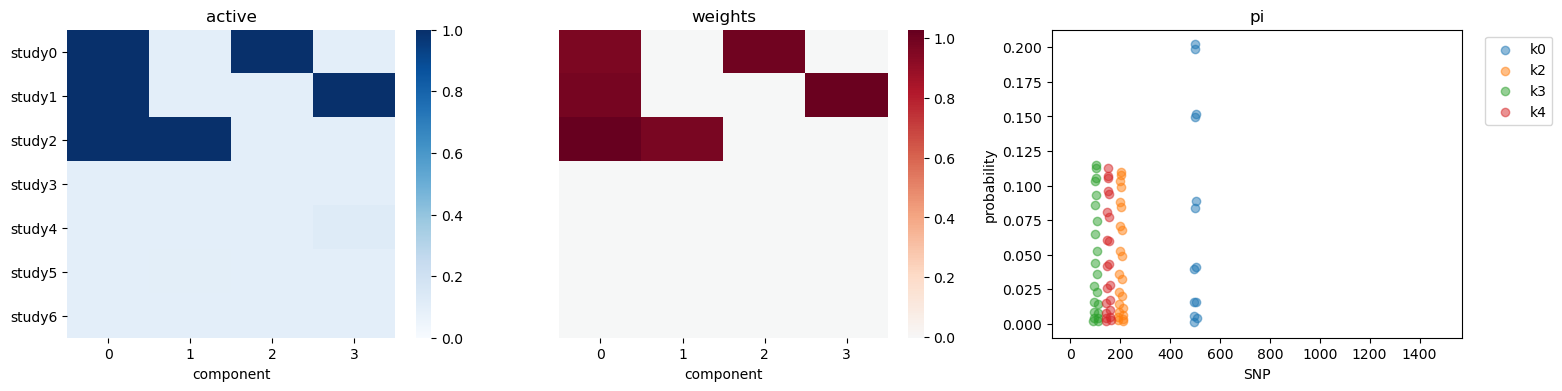

CPU times: user 8.9 s, sys: 1.64 s, total: 10.5 s
Wall time: 3.01 s


In [66]:
%%time
a = 1
cafehs1 = fit_cafeh_summary(LD_df, a * beta_df, a * stderr_df, n=n)
cafehs1.plot_components()

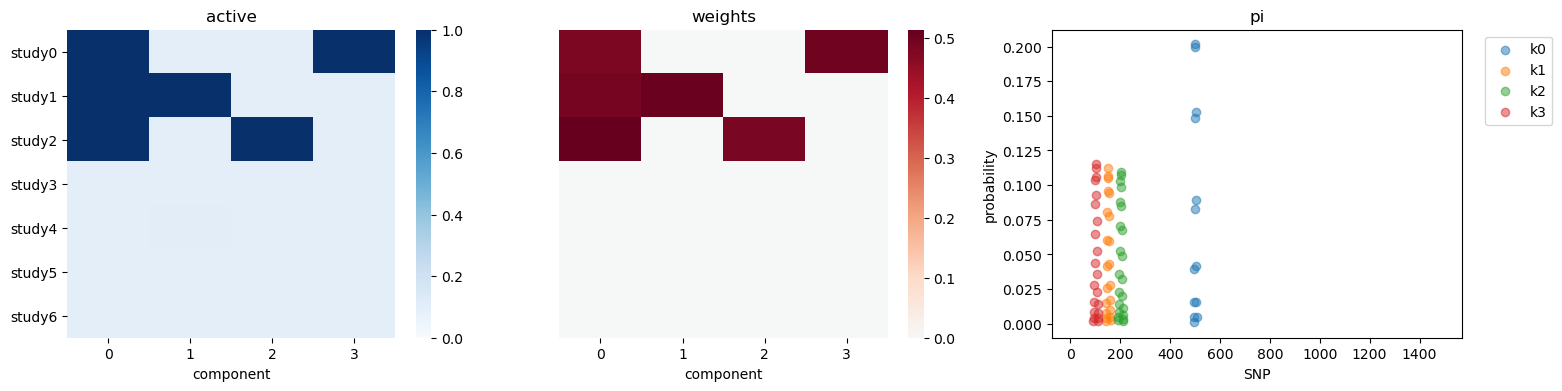

CPU times: user 9.85 s, sys: 1.96 s, total: 11.8 s
Wall time: 3.34 s


In [60]:
%%time
a = 0.5
cafehs2 = fit_cafeh_summary(LD_df, a * beta_df, a * stderr_df, n=n)
cafehs2.plot_components()

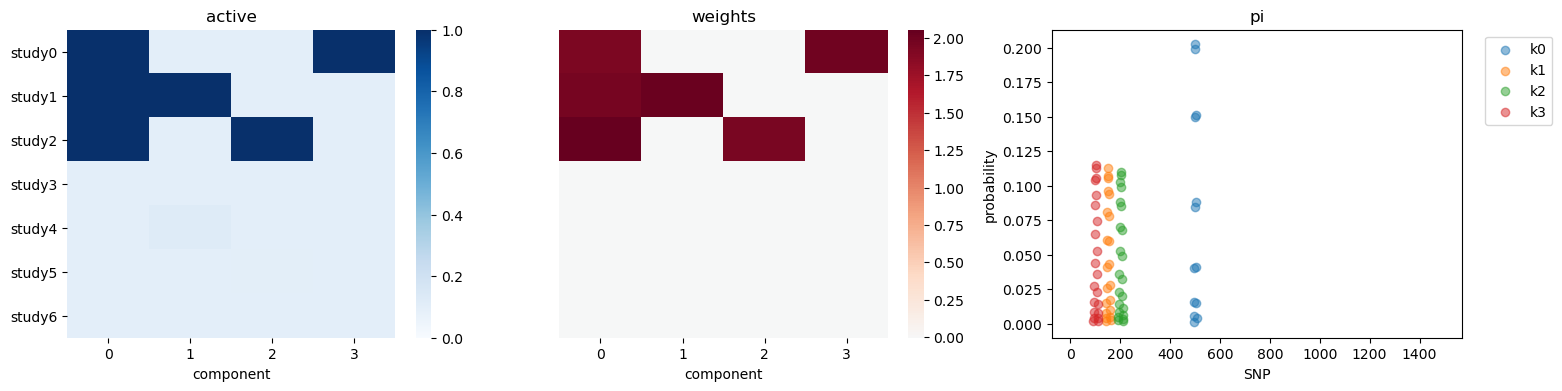

CPU times: user 10.2 s, sys: 2.18 s, total: 12.4 s
Wall time: 3.92 s


In [61]:
%%time
a = 2
cafehs3 = fit_cafeh_summary(LD_df, a * beta_df, a * stderr_df, n=n)
cafehs3.plot_components()

In [62]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color='red', linewidth=0.5)

## PIPs

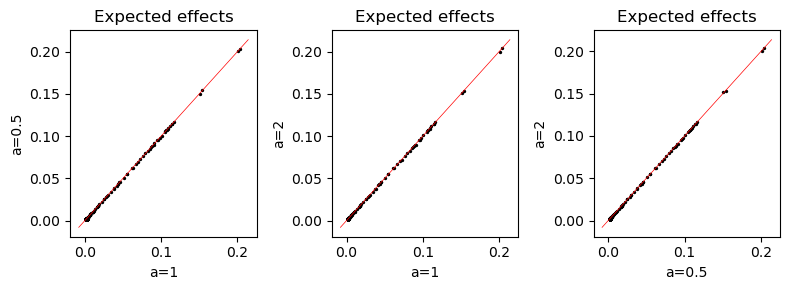

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))

plt.sca(ax[0])
plt.scatter(get_pip(cafehs1), get_pip(cafehs2), color='k', s=2);
abline(1, 0)
plt.title('Expected effects')
plt.xlabel('a=1')
plt.ylabel('a=0.5')

plt.sca(ax[1])
plt.scatter(get_pip(cafehs1), get_pip(cafehs3), color='k', s=2);
abline(1, 0)
plt.title('Expected effects')
plt.xlabel('a=1')
plt.ylabel('a=2')

plt.sca(ax[2])
plt.scatter(get_pip(cafehs2), get_pip(cafehs3), color='k', s=2);
abline(1, 0)
plt.title('Expected effects')
plt.xlabel('a=0.5')
plt.ylabel('a=2')

plt.tight_layout()

In [125]:
def get_expected_effects(fit):
    q = fit.active[:,:, None] * fit.pi[None]
    return (q * fit.weight_means).sum((0, 1))

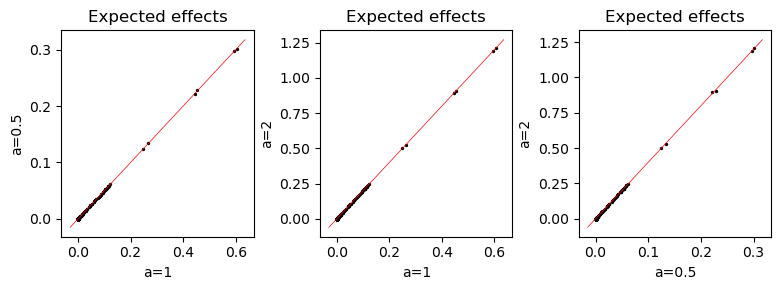

In [126]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))

weights = lambda fit: get_expected_weights(fit).flatten()

plt.sca(ax[0])
plt.scatter(get_expected_effects(cafehs1), get_expected_effects(cafehs2), color='k', s=2);
plt.title('Expected effects')
plt.xlabel('a=1')
plt.ylabel('a=0.5')
abline(0.5, 0)

plt.sca(ax[1])
plt.scatter(get_expected_effects(cafehs1), get_expected_effects(cafehs3), color='k', s=2);
plt.title('Expected effects')
plt.xlabel('a=1')
plt.ylabel('a=2')
abline(2, 0)

plt.sca(ax[2])
plt.scatter(get_expected_effects(cafehs2), get_expected_effects(cafehs3), color='k', s=2);
plt.title('Expected effects')
plt.xlabel('a=0.5')
plt.ylabel('a=2')
abline(4, 0)

plt.tight_layout()

Although there are small differences, note that CAFEHS is using optimized using Monte-Carlo estimates of the ELBO, so there is some variability in the end state.

Also note that the prior on the effect behaves differently for different scalings $a$. In particular a fixed prior variance $\b \sim N(0, \sigma^2_0)$ would induce stronger shrinkage the larger we set $a$. When we estimate the prior variance, the setting of the prior variance amounts to a different initialization of the algorithm, which may also change the results.

### References 

1. Zhu, X., & Stephens, M. (2017). Bayesian large-scale multiple regression with summary statistics from genome-wide association studies. The annals of applied statistics, 11(3), 1561.
